# Value-based bidding

Value-based bidding is a strategy where advertisers set bids based on the estimated value each ad click brings to their business, aiming to optimize return on investment.

### Best-in-class solution

We define value using CLV, the present value of revenue flows:

$$\text{CLV}_i = \frac{P_i \times V_i \times r_i}{1 + \text{WACC} - r_i}$$

- $P_i$ is price per seat
- $V_i$ is seat volume
- $r_i$ is retention rate
- $WACC$ is the weighted-average cost of capital

We need to predict CLV for each customer in the first 24-hours of sign up so we can send that information to advertisers.

**Tl;dr:**
1. Calculate CLV using known information for current signups.
2. Train regression model to predict CLV on unseen signups.

**Calculating CLV using known information**
- Revenue ($P_i \cdot V_i$): current MRR
- $r_i$: A function of package, with each package estimated using an exponential survival model
- $WACC$: 15%

### Good-enough solution

We still define value as CLV, but we focus on predicting which product the person will convert to (if any).


**Tl;dr:**
1. Calculate CLV using known information for current signups.
2. Train classification model to predict land package on unseen signups.
3. Assign the mean CLV of current customers on that package to that package.


# Data

**$y$ variable**
- $CLV_i$

**$x$ variables**
- Segment [str]
- Education email flag [str]
- Company email flag [str]
- Industry [str]
- Revenue [str]
- Employees [str]
- City [str]
- State [str]
- Country [str]
- Data residency [str]
- GA signup flag [str]
- FB signup flag [str]
- Feature counts in first 1 day [int]

# Import

### Import local XLSX file

In [ ]:
def import_data():
    import pandas as pd
    file_path = '/Users/patricksweeney/growth/01_Acquisition/03_Value-based bidding/VBB Train 2.xlsx'
    data = pd.read_excel(file_path)
    return data

data = import_data()
data.head()

### Check data

In [ ]:
def find_missing_values(data):
    missing_values = data.isnull().sum()
    print("Features with missing values are...")
    print(missing_values)

find_missing_values(data)

# Feature engineering

### One hot encode


One-hot encoding converts categorical variables into a form that can be provided to machine learning algorithms to improve prediction accuracy. It creates binary columns for each category and avoids the misleading ordinal relationships that numeric encoding might imply.

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

def one_hot_encode(data, exclude):
    # Ensure that 'data' is a pandas DataFrame
    if not isinstance(data, pd.DataFrame):
        raise TypeError("Input data must be a pandas DataFrame.")

    # Validate 'exclude' as a list
    if not isinstance(exclude, list):
        raise TypeError("'exclude' must be a list of columns.")

    # Select string and categorical columns to encode, excluding the specified columns
    columns_to_encode = data.select_dtypes(include=['object', 'category']).columns
    columns_to_encode = [col for col in columns_to_encode if col not in exclude]

    # Apply OneHotEncoder
    encoder = OneHotEncoder(sparse=False, drop='if_binary')
    encoded_data = pd.DataFrame(encoder.fit_transform(data[columns_to_encode]))

    # Fix column names after encoding
    encoded_data.columns = encoder.get_feature_names_out(columns_to_encode)

    # Drop original columns and concatenate encoded data
    data = data.drop(columns_to_encode, axis=1)
    data = pd.concat([data, encoded_data], axis=1)

    return data


data = one_hot_encode(data, ['workspace_id', 'product'])
data.head()

### Best-case performance

In [15]:
def best_case(data, y_variable, exclude, continuous_y=True):
    # Importing necessary libraries
    import pandas as pd
    import numpy as np
    from scipy.stats import entropy, differential_entropy
    from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

    # Exclude specified variables and separate X and Y
    X = data.drop(columns=[y_variable] + exclude)
    Y = data[y_variable]

    # Calculate the entropy of Y-variable
    if continuous_y:
        # Use differential_entropy for continuous Y
        y_entropy = differential_entropy(Y)
        # Calculate mutual information for continuous Y
        mi = mutual_info_regression(X, Y)
    else:
        # Use entropy for discrete Y
        value_counts = Y.value_counts()
        y_entropy = entropy(value_counts)
        # Calculate mutual information for discrete Y
        mi = mutual_info_classif(X, Y)

    total_mi = np.sum(mi)

    # Proportion of uncertainty reduced
    proportion_reduced = total_mi / y_entropy if y_entropy > 0 else 0

    # Print results
    print(f"Entropy of Y-variable: {y_entropy}")
    print(f"Total Mutual Information: {total_mi}")
    print(f"Proportion of Uncertainty Reduced: {proportion_reduced}")

# Example usage
best_case(data, 'product', ['clv', 'workspace_id'], continuous_y=False)


Entropy of Y-variable: 0.1704310430992885
Total Mutual Information: 0.5505989063640913
Proportion of Uncertainty Reduced: 3.2306256909037825


### Remove redundant features

In [ ]:
import pandas as pd
from sklearn.feature_selection import SelectPercentile, mutual_info_regression, mutual_info_classif

def scikit_prune_features(data, y_variable, exclude, percentile):
    # Ensure that 'exclude' is a list
    if not isinstance(exclude, list):
        raise TypeError("'exclude' must be a list of columns.")

    # Separate the features and the target variable
    X = data.drop(columns=[y_variable] + exclude)
    y = data[y_variable]

    # Determine the score function based on the target variable type
    if y.dtype == 'float':
        score_func = mutual_info_regression
    else:
        score_func = mutual_info_classif

    # Apply SelectPercentile
    selector = SelectPercentile(score_func=score_func, percentile=percentile)
    X_new = selector.fit_transform(X, y)

    # Get the selected feature names
    selected_features = X.columns[selector.get_support()]

    # Combine selected features with excluded columns and target variable
    final_data = pd.concat([data[exclude], data[selected_features], data[[y_variable]]], axis=1)

    return final_data

# Example usage:
data = scikit_prune_features(data, 'clv', ['workspace_id', 'product'], 33)
data.head()


### PCA

Principal Component Analysis (PCA) reduces the dimensionality of data by transforming it into principal components, capturing the most variance with fewer features. This technique simplifies the dataset while retaining essential information, enhancing the performance and interpretability of machine learning models.

In [ ]:
def pca(data, y_variable, exclude):
    # Importing necessary libraries
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler

    # Excluding specified variables
    exclude_columns = [y_variable] + exclude
    pca_data = data.drop(columns=exclude_columns)

    # Standardizing the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(pca_data)

    # Performing PCA
    pca = PCA()
    pca.fit(scaled_data)
    pca_data_transformed = pca.transform(scaled_data)

    # Plotting Scree Plot
    plt.figure(figsize=(10, 4))
    plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
    plt.ylabel('Explained Variance')
    plt.xlabel('Principal Components')
    plt.title('Scree Plot')
    plt.show()

    # Plotting Cumulative Explained Variance
    plt.figure(figsize=(10, 4))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Explained Variance by PCA Components')
    plt.show()


    # Plotting PCA Score Plot for first two principal components
    plt.figure(figsize=(8, 6))
    plt.scatter(pca_data_transformed[:, 0], pca_data_transformed[:, 1])
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('PCA Score Plot')
    plt.show()

    return pca_data_transformed

pca_data = pca(data, 'clv', ['product', 'workspace_id'])


# Predicting $CLV_i$ in first 24-hours

Performance here is terrible: 0% $r^2$

### Regression with gradient boosting


Gradient Boosting is a machine learning technique that builds models sequentially, with each new model correcting the errors of the previous ones, optimizing for a loss function. This approach combines weak predictive models, typically decision trees, into a stronger ensemble, offering high accuracy in various tasks.

In [ ]:
def gradient_boosting_regression(data, y_variable, random_state=42):
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.model_selection import train_test_split, cross_val_score, KFold
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import math
    from scipy.interpolate import UnivariateSpline

    # Separate the features and target variable
    X = data.drop(columns=[y_variable]).select_dtypes(include=np.number)
    y = data[y_variable]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    # 1. Train model
    model = GradientBoostingRegressor(random_state=random_state)
    model.fit(X_train, y_train)

    # 2. Test model
    cv = KFold(n_splits=10, shuffle=True, random_state=random_state)
    cross_val_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
    
    # Rounding the scores to two decimal places
    rounded_scores = [round(score, 2) for score in cross_val_scores]
    print("Cross-validation scores (R2):", rounded_scores)

    # Predictions
    y_pred = model.predict(X_test)

    # 3. Performance Metrics
    mse = round(mean_squared_error(y_test, y_pred), 2)
    r2 = round(r2_score(y_test, y_pred), 2)
    mae = round(mean_absolute_error(y_test, y_pred), 2)
    print(f"Mean Squared Error: {mse}")
    print(f"R2 Score: {r2}")
    print(f"Mean Absolute Error: {mae}")

    # 4. Plot Predictions vs Actual with adjusted log10 scale
    offset = 1e-6  # Small constant to offset zero or negative values
    adjusted_y_test = np.log10(y_test + offset)
    adjusted_y_pred = np.log10(y_pred + offset)

    plt.scatter(adjusted_y_test, adjusted_y_pred)
    plt.xlabel("Actual Values (log10 scale)")
    plt.ylabel("Predicted Values (log10 scale)")
    plt.title("Predicted vs Actual Values (log10 scale)")
    
    # Line for perfect predictions
    min_val = min(adjusted_y_test.min(), adjusted_y_pred.min())
    max_val = max(adjusted_y_test.max(), adjusted_y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--')

    plt.show()
    
    
    # 5. Feature Importance - Updated to show only top 10
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)[-10:]  # Get the indices of the top 10 features
    
    plt.barh(X.columns[sorted_idx], feature_importance[sorted_idx])
    plt.xlabel("Gradient Boosting Feature Importance")
    plt.title("Top 10 Features")
    plt.show()

    plt.tight_layout()
    plt.show()

    return model

model = gradient_boosting_regression(data, 'clv')

# Predicting $Package_i$ in first 24 hours

We need to be minimising our false negative rate, even if we have an overly sensitive classifier.

### Classification with gradient boosting

In [27]:
def gradient_boosting(data, y_variable, exclude):
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
    from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, cohen_kappa_score
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    random_state = 2
    
    # Ensure 'exclude' is a list
    if not isinstance(exclude, list):
        raise TypeError("'exclude' must be a list of columns.")

    # Separate features and target variable
    X = data.drop(columns=[y_variable] + exclude).select_dtypes(include=np.number)
    y = data[y_variable]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    # Train model
    model = GradientBoostingClassifier()
    model.fit(X_train, y_train)

    # Test model
    cv = StratifiedKFold(n_splits=10)
    cross_val_scores = cross_val_score(model, X, y, cv=cv, scoring='f1_macro')
    print("Cross-validation scores:", cross_val_scores)

    # Predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    # 4. Classification report
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))

    # Compute ROC, AUC, Precision-Recall for each class
    classes = np.unique(y)
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve((y_test == cls).astype(int), y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        precision, recall, _ = precision_recall_curve((y_test == cls).astype(int), y_proba[:, i])
        
        # ROC Curve
        plt.figure()
        plt.plot(fpr, tpr, label='Class %s AUC = %0.2f' % (cls, roc_auc))
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC for class %s' % cls)
        plt.legend(loc="lower right")
        plt.show()

        # Precision-Recall Curve
        plt.figure()
        plt.plot(recall, precision)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve for class %s' % cls)
        plt.show()
    

    # # Compute and plot Lift Chart
    # df_lift = pd.DataFrame({'y_test': y_test, 'y_proba': y_proba})
    # df_lift = df_lift.sort_values(by='y_proba', ascending=False)
    # df_lift['decile'] = pd.qcut(df_lift['y_proba'], 10, labels=False)
    # df_lift['num_positive'] = df_lift['y_test'].cumsum()
    # df_lift['total'] = df_lift.index + 1
    # df_lift['lift'] = df_lift['num_positive'] / df_lift['total']

    
    # Cross-validation score
    print("Average cross-validation score:", np.mean(cross_val_scores))

    # Cohen's Kappa
    kappa = cohen_kappa_score(y_test, y_pred)
    print("Cohen's Kappa:", kappa)

    plt.tight_layout()
    plt.show()
    
    return model


Cross-validation scores: [0.28032135 0.25771601 0.37013766 0.27425452 0.28749732 0.31018012
 0.28207275 0.39722544 0.38482864 0.35765342]
               precision    recall  f1-score   support

     Business       0.00      0.00      0.00        16
   Enterprise       0.00      0.00      0.00         5
No conversion       0.97      1.00      0.98     12196
      Starter       0.47      0.07      0.12       327
         Team       0.27      0.05      0.08        64

     accuracy                           0.97     12608
    macro avg       0.34      0.22      0.24     12608
 weighted avg       0.95      0.97      0.95     12608

Confusion matrix:
[[    0     0    14     2     0]
 [    0     0     5     0     0]
 [    3     0 12164    22     7]
 [    0     0   304    22     1]
 [    0     0    60     1     3]]


/Users/patricksweeney/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/patricksweeney/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/patricksweeney/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


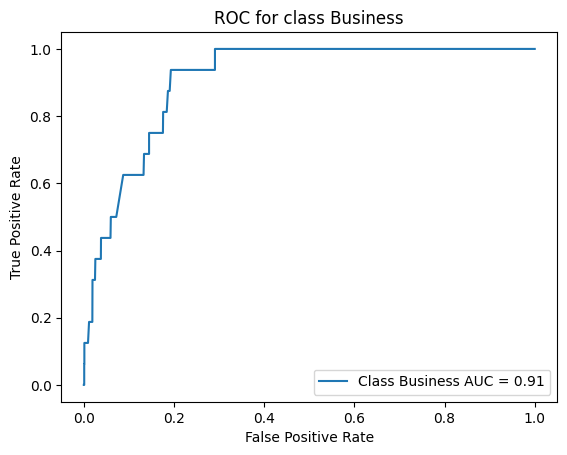

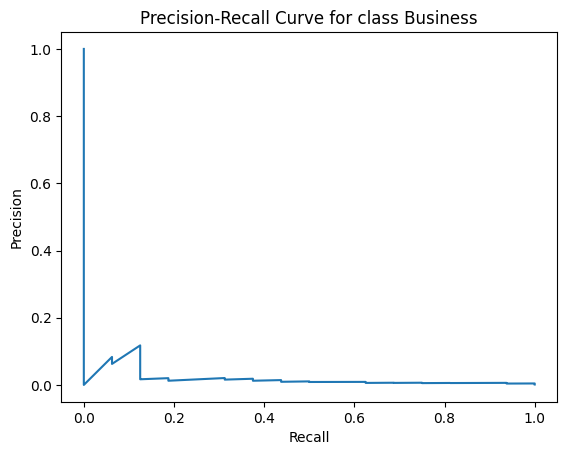

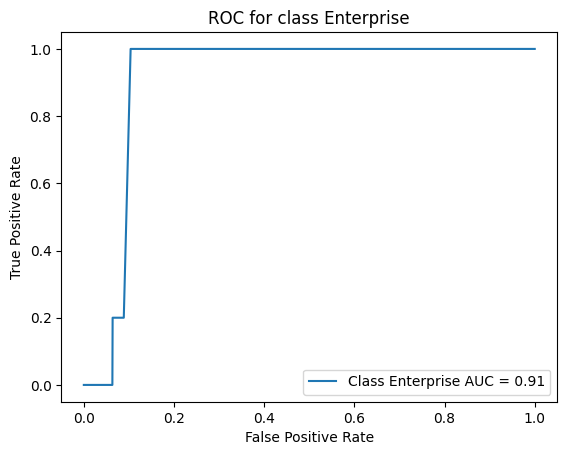

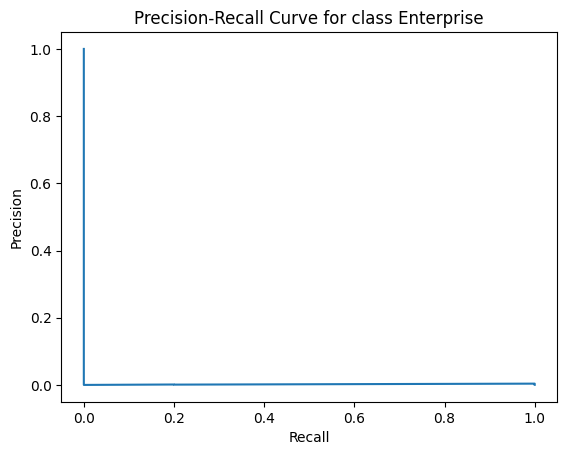

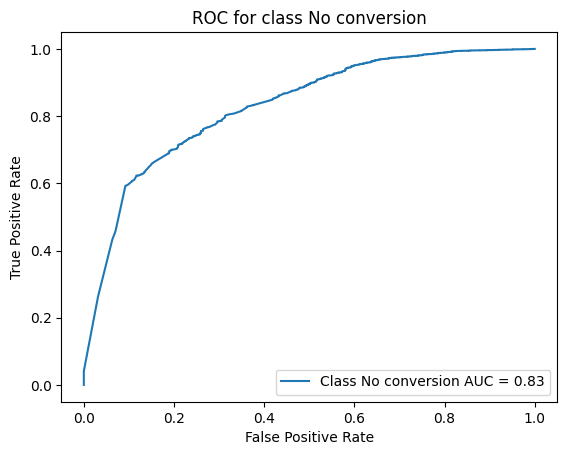

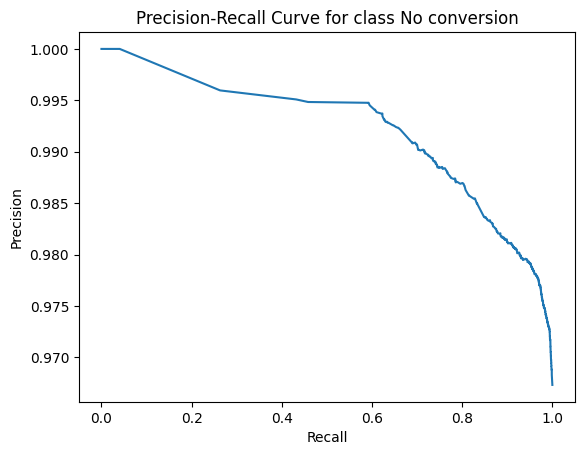

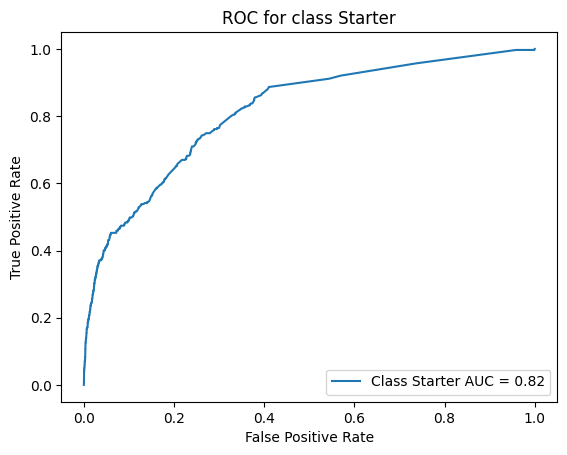

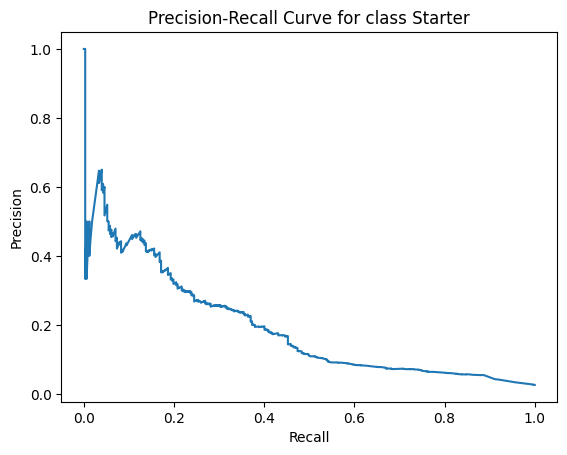

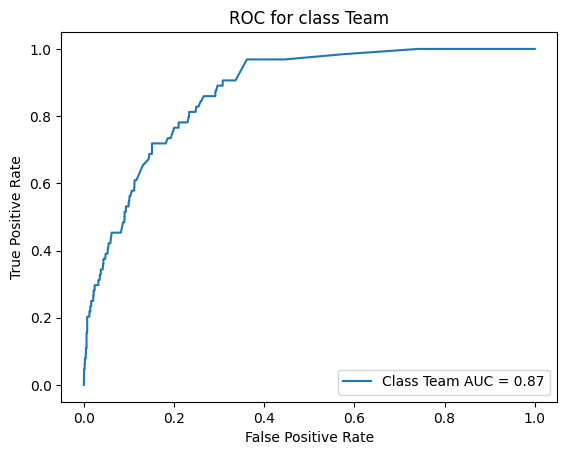

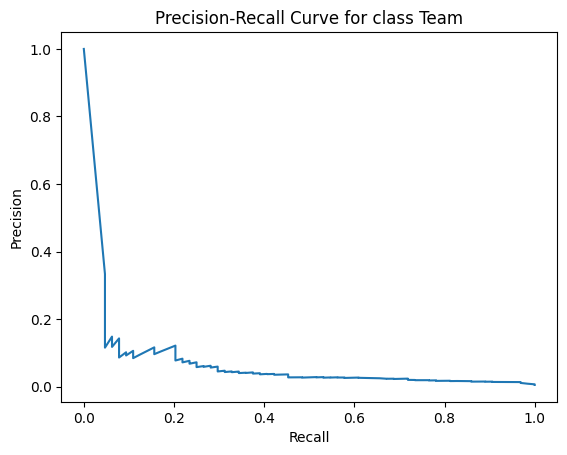

ValueError: Per-column arrays must each be 1-dimensional

In [28]:
model = gradient_boosting(data, 'product', ['clv'])

# Get value-weightings

In [29]:
def get_predictions(data, model, y_variable, exclude):
    import pandas as pd
    import numpy as np

    # Filter data where the target variable equals 0
    target_data = data

    # Exclude specified variables, separate the features, and retain the index
    X_target = target_data.drop(columns=[y_variable] + exclude).select_dtypes(include=np.number)

    # Make predictions
    predictions = model.predict(X_target)
    probabilities = model.predict_proba(X_target)[:, 1]

    # Append predictions and probabilities to the original data
    data.loc[target_data.index, 'Prediction'] = predictions
    data.loc[target_data.index, 'Probability'] = probabilities

    return data

# Example usage
predictions = get_predictions(data, model, 'product', ['clv'])


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Probability
- weighting


In [26]:
def get_weightings(data, prediction_column, clv_column):
    import pandas as pd

    # Calculate the average CLV for each prediction category
    average_clvs = data.groupby('product')[clv_column].mean()

    # Create a new column 'weighting' with the average CLV for each prediction
    data['weighting'] = data[prediction_column].map(average_clvs)

    return data

weightings = get_weightings(data, 'Prediction', 'clv')
weightings.head()


,workspace_id,product,transcription_count,highlight_count,tag_count,invite_count,note_viewed_user_count,tag_viewed_user_count,segment_FREE_EMAIL,segment_OTHER,...,country_code_ZA,country_code_ZW,residency_region_Unknown,residency_region_eu-a,residency_region_us-a,residency_region_us-b,clv,Prediction,Probability,weighting
0,00095959-e65b-4256-aeba-06464ae106ac,No conversion,4,0,0,0,0,0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,No conversion,0.001644,0.0
1,00786b99-40f5-4703-a772-3026df9827ff,No conversion,0,0,0,0,0,0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,No conversion,0.000166,0.0
2,00ddc9a5-85c6-44d9-9968-c37cdad31fcc,No conversion,0,0,0,0,0,0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,No conversion,0.000161,0.0
3,0160b311-e4f8-4bbd-a06f-e2b4c80d40a1,No conversion,0,0,0,0,1,0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,No conversion,0.000122,0.0
4,0172345b-7159-4c99-88d9-3e4fa521f14d,No conversion,0,0,0,0,0,0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,No conversion,0.000161,0.0


# Save predictions

In [ ]:
def save_predictions(predictions, filename):
    import pandas as pd

    # Ensure the filename ends with '.xlsx'
    if not filename.endswith('.xlsx'):
        filename += '.xlsx'

    # Save to Excel
    predictions.to_excel(filename, index=False)

save_predictions(weightings, 'predictions_vbb.xlsx')